# Porasil example

In [1]:
import os
import numpy as np
import scipy.stats
import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
from mantid.simpleapi import mtd
from mantid import simpleapi as api

In [3]:
from drtsans.tof import eqsans

## Settings for loading data

In [4]:
config = dict(#mask="data/EQSANS_88980_mask.xml",
              bin_width=0.5,
              low_tof_clip=500,
              high_tof_clip=2000,
              detector_offset=0,
              sample_offset=340,
              flux_method='proton charge',
              flux="/SNS/EQSANS/shared/instrument_configuration/bl6_flux_at_sample",
              sensitivity_file_path="/SNS/EQSANS/shared/NeXusFiles/EQSANS/2017A_mp/Sensitivity_patched_thinPMMA_4m_79165_event.nxs",
              dark_current="/SNS/EQSANS/shared/NeXusFiles/EQSANS/2017B_mp/EQSANS_86275.nxs.h5",
             )

mask_file = "/SNS/users/m2d/git/analysis_playground/eqsans/notebooks/data/EQSANS_88980_mask.xml"

## Find beam center
For some reason there is a sign different between the old and new.

In [5]:
# The new way of dealing with the beam center is in real space, relative to the center of the detector.
# The EQSANS detector is 192 x 256 pixels, and the pixel sizes are 5.5 mm x 4.3 mm
x_center = -(192/2.0 - 90.93) * 0.0055
y_center = (256/2.0 - 131.47) * 0.0043
print("Old reduction's beam center in real space: %g %g" % (x_center, y_center))

db_ws = eqsans.load_events("EQSANS_88973")
center = eqsans.center_detector(db_ws)
print("Beam center found: %g %g" % (center[0], center[1]))

config['x_center'] = x_center
config['y_center'] = y_center

Old reduction's beam center in real space: -0.027885 -0.014921
Beam center found: -0.0252392 -0.0170794


## Prepare the data for I(Q) calculation

In [6]:
%%time
absolute_scale = 0.0208641883
sample_thickness = 0.1  # mm

# Load and prepare scattering data
ws = eqsans.prepare_data("EQSANS_88980", mask=mask_file, **config)

# Apply transmission
apply_transmission = True
if apply_transmission:
    ws_tr_sample = eqsans.prepare_data("EQSANS_88975", **config)
    ws_tr_direct = eqsans.prepare_data("EQSANS_88973", **config)
    tr_ws = eqsans.calculate_transmission(ws_tr_sample, ws_tr_direct, radius=None, radius_unit='mm')
    ws = eqsans.apply_transmission_correction(ws, trans_workspace=tr_ws)

# Background
ws_bck = eqsans.prepare_data("EQSANS_88979", mask=mask_file, **config)

# Apply transmission
if apply_transmission:
    ws_tr_back = eqsans.prepare_data("EQSANS_88974", **config)
    ws_tr_direct = eqsans.prepare_data("EQSANS_88973", **config)

    tr_ws = eqsans.calculate_transmission(ws_tr_back, ws_tr_direct, radius=None, radius_unit='mm')
    ws_bck = eqsans.apply_transmission_correction(ws_bck, trans_workspace=tr_ws)

ws = eqsans.subtract_background(ws, background=ws_bck)

ws /= sample_thickness
ws *= absolute_scale

CPU times: user 1min 12s, sys: 15.3 s, total: 1min 28s
Wall time: 1min 28s


In [7]:
%%time
table_ws_list = eqsans.prepare_momentum_transfer(ws, wavelength_binning=[config['bin_width']])

CPU times: user 319 ms, sys: 3.9 ms, total: 323 ms
Wall time: 199 ms


In [10]:
%%time
iq_ws_f1 = eqsans.cal_iq(table_ws_list[0], bins=100, log_binning=True)

# Save output
filepath = os.path.join(os.path.expanduser('~'), iq_ws_f1.name()+'.txt')
api.SaveAscii(iq_ws_f1.name(), Filename=filepath, WriteSpectrumID=False, WriteXError=True)

IndexError: list index out of range

In [9]:
%%time
if len(table_ws_list) == 2:
    iq_ws_f2 = eqsans.cal_iq(table_ws_list[1], bins=150, log_binning=True)

    filepath = os.path.join(os.path.expanduser('~'), iq_ws_f2.name()+'.txt')
    api.SaveAscii(iq_ws_f2.name(), Filename=filepath, WriteSpectrumID=False, WriteXError=True)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 15 µs


# Plot the results

To compare to reference data, execute the `EQSANS_porasil.py` script on one of the
analysis computers to create the reference data.

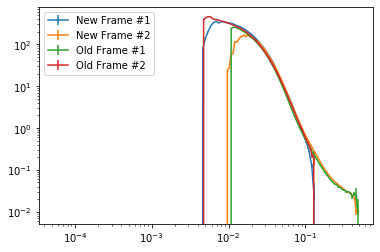

In [5]:
scale_match = 300000

data_dir = os.path.expanduser('~')
reduced_f1 = np.loadtxt(os.path.join(data_dir, 'EQSANS_88980_frame1_iq.txt'), delimiter=',')
reduced_f2 = np.loadtxt(os.path.join(data_dir, 'EQSANS_88980_frame2_iq.txt'), delimiter=',')

fig, ax = plt.subplots()
ax.errorbar(reduced_f1.T[0], reduced_f1.T[1]/scale_match, yerr=reduced_f1.T[2]/scale_match, label="New Frame #1")
ax.errorbar(reduced_f2.T[0], reduced_f2.T[1]/scale_match, yerr=reduced_f2.T[2]/scale_match, label="New Frame #2")

# To compare to reference data, execute the EQSANS_porasil.py script on one of the
# analysis computers to create the reference data.
if os.path.exists(os.path.join(data_dir, 'EQSANS_88980_frame1_iq.txt')):
    ref_f1 = np.loadtxt(os.path.join(data_dir, 'EQSANS_88980_frame1_iq_ref.txt'), delimiter=',')
    ref_f2 = np.loadtxt(os.path.join(data_dir, 'EQSANS_88980_frame2_iq_ref.txt'), delimiter=',')
    ax.errorbar(ref_f1.T[0], ref_f1.T[1], yerr=ref_f1.T[2], label="Old Frame #1")
    ax.errorbar(ref_f2.T[0], ref_f2.T[1], yerr=ref_f2.T[2], label="Old Frame #2")

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()